# Random forest lepton flavor study
(Oct 26, 2016)

This study was done using the the same, very simliar, set-up and methodology to what was done with TMVA over during 2015-mid2016. There are a few glaring mistakes and over sights which will be noted but not corrected in this study. The issues are outlined below. 

### Issues 

There are a few issues to note. First that the original forest was not trained on 1/3 of the mc, but ~ 1/3 of WW and the rest of the same order as the WW.  ( 50,000-WW, 70,000-DY, 33,000-TT ) More importantly when producing yeild tables the entire Monte Carlo dataset set was used, including the portion of the set which had been used for training. What worse is that only ~2/3 of the WW set was avalible. So over 50% of the data set used to test on was also used to train. :( 

Other things: 

- At this point in time bagged fraction isn't known to be a tunable parameter.

- Sklearn seems to cut a bit more harshly on TT then DY as the yields for TT are abit lower while DY is markedly higher then what's produced by TMVA.

- 100 trees were trained for each flavor and for the combined set here.  The TMVA forest held 300 trees.

### Future 

I plan to move away from TMVA.  Before doing so I need to determine why their is such a large difference in the DY yields. I plan on completing the analysis with 1/3 of the MC where the number of DY and TT are weighted such that the weighted sum of each process are the same magnitude.

link to that note book: 

=========================


## Set up:

In [1]:
run prep_ana.py

loading data frame named df.
finished loading data frame
unc_mc_process and scales are dictionaries
scale_data = (5.27/19.7)


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
%matplotlib inline

In [3]:
df_WW = rp.read_root("data/WW_tot_complete_10.root", "trees_vec")
df_DY = rp.read_root("data/DY_ll_complete_10.root", "trees_vec")
df_TT = rp.read_root("data/TT_ll_complete_10.root", "trees_vec")

In [69]:
def pre_cuts( df ):
    dif_lep = df.lep_Type > 0
    sam_lep = df.lep_Type < 0
    z_mass = (df.mll < 76) | (df.mll > 106 )
    qt_s = (df.qT > 45)
    qt_d = (df.qT > 30)
    met_prj = (df.METProj_sin > 20) & (df.METProj_trk_sin > 20)
    nBjet = df.numb_BJet == 0
    extra_lep = df.numbExtraLep == 0
    
    s_df = df[ sam_lep & z_mass & nBjet & extra_lep & met_prj & qt_s ]
    d_df = df[ dif_lep & nBjet & extra_lep ]#& met_prj & qt_d]
    
    return pd.concat([ s_df, d_df])

In [70]:
df = pd.concat( [df_WW, df_TT, df_DY] )
df = pre_cuts(df)
df = df.reset_index()

In [72]:

train_same_DY = df[(df.lep_Type < 0) & (df.process == "DY")].sample( frac=.4)
train_same_WW = df[(df.lep_Type < 0) & (df.process == "WW")].sample( n=train_same_DY.shape[0]*2 )
train_same_TT = df[(df.lep_Type < 0) & (df.process == "TT")].sample( n=train_same_DY.shape[0]*2 )
train_same = pd.concat([ train_same_WW, train_same_DY, train_same_TT])

train_diff_DY = df[(df.lep_Type > 0) & (df.process == "DY")].sample( frac=.4 )
train_diff_WW = df[(df.lep_Type > 0) & (df.process == "WW")].sample( n=train_diff_DY.shape[0]*2 )
train_diff_TT = df[(df.lep_Type > 0) & (df.process == "TT")].sample( n=train_diff_DY.shape[0]*2 )
train_diff = pd.concat([ train_diff_WW, train_diff_DY, train_diff_TT])

print train_same[train_same.process == "WW"].shape, train_same[train_same.process == "DY"].shape, train_same[train_same.process == "TT"].shape
print train_diff[train_diff.process == "WW"].shape, train_diff[train_diff.process == "DY"].shape, train_diff[train_diff.process == "TT"].shape

(4436, 62) (2218, 62) (4436, 62)
(11748, 62) (5874, 62) (11748, 62)


In [73]:
#Testing
test = df.drop( train_same.index )
test = test.drop( train_diff.index )

In [74]:
#Labels
labels_s = np.empty( train_same.shape[0] )
labels_d = np.empty( train_diff.shape[0] )

labels_d[(train_diff.process == "WW").as_matrix()] = 1
labels_d[(train_diff.process == "DY").as_matrix()] = 2
labels_d[(train_diff.process == "TT").as_matrix()] = 2

labels_s[(train_same.process == "WW").as_matrix()] = 1
labels_s[(train_same.process == "DY").as_matrix()] = 2
labels_s[(train_same.process == "TT").as_matrix()] = 2


In [75]:
#weights
weights_d = np.empty(train_diff.shape[0] )
weights_s = np.empty(train_same.shape[0] )



weights_d[(train_diff.process == "WW").as_matrix()] = 1
weights_d[(train_diff.process == "DY").as_matrix()] = 1
weights_d[(train_diff.process == "TT").as_matrix()] = 1

weights_s[(train_same.process == "WW").as_matrix()] = 1
weights_s[(train_same.process == "DY").as_matrix()] = 1
weights_s[(train_same.process == "TT").as_matrix()] = 1


In [76]:
features = ['numb_jets', 'lep2_pt', 'METProj', 'METProj_trk_sin', 'qT', 'mll', 'mllMET', 'metMod', 'dPhiLLMET', 'dPhiLLJet', 'dPhiMETJet', 'dPhiLL', 'HT', 'recoil'] +\
           ['jet1_csv', 'lep_Type']

In [77]:
train_diff[features].head()

,numb_jets,lep2_pt,METProj,METProj_trk_sin,qT,mll,mllMET,metMod,dPhiLLMET,dPhiLLJet,dPhiMETJet,dPhiLL,HT,recoil,jet1_csv,lep_Type
198580,0,41.110065,22.181072,5.467548,17.882412,109.361435,150.720428,31.733803,2.827090,0.000000,0.000000,2.981962,0.000000,15.733088,-2.000000,1
168866,1,39.514809,52.153618,30.676060,29.925282,93.416214,172.354935,64.837433,2.887120,0.118858,3.005978,2.599808,31.929033,36.658241,-1.000000,1
203348,0,38.171062,20.024984,18.303606,44.265953,65.591751,102.448792,22.788109,2.039417,0.000000,0.000000,1.945958,0.000000,39.592514,-2.000000,1
209561,0,11.005165,85.409874,85.409874,73.065025,17.773783,160.187653,85.409874,3.090837,0.000000,0.000000,0.617532,0.000000,12.979522,-2.000000,1
165403,1,35.230034,56.762665,53.691147,36.694717,95.611862,185.682678,59.765289,2.880779,1.224048,2.178359,2.679896,37.757317,26.088093,0.578647,1


# Classification training and testing

In [58]:
from sklearn.ensemble import RandomForestClassifier


## Different flavor 

In [21]:
clf_d = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_samples_split=10, max_depth=15, max_features='sqrt')
clf_s = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_samples_split=10, max_depth=15, max_features='sqrt')
#n_estimators=150

In [22]:
clf_d = clf_d.fit( np.float32(train_diff[features].values) , np.float32(labels_d), sample_weight=weights_d)

In [24]:
print clf_d.score(np.float32(train_diff[features].values), np.float32(labels_d), weights_d)

0.941743275451


In [25]:
test_d = test[test.lep_Type > 0]
pred_d = clf_d.predict_proba(np.float32(test_d[features].values))

In [26]:
test_d["pred"] = pred_d[:,0]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


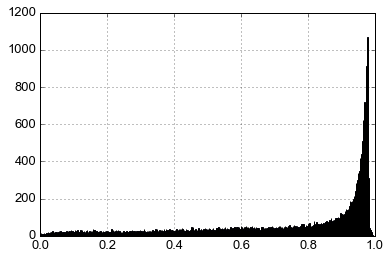

In [28]:
test_d[ test_d.process == "WW" ].pred.hist(bins=1000)

In [49]:
for process in scales.keys():
    if process in test_d.process.unique():
        print process, test_d[ (test_d.process == process) & (test_d.pred > .8429)].shape[0] *  scales[process] * float(df[(df.process == process) & (df.lep_Type > 0)].shape[0])/float(test_d[test_d.process == process].shape[0])

WW 4588.31247463
DY 376.908384905
TT 454.19777286


## Same Flavor

In [78]:
clf_s = clf_s.fit( np.float32(train_same[features].values) , np.float32(labels_s), sample_weight=weights_s)

In [79]:
print clf_s.score(np.float32(train_same[features].values), np.float32(labels_s), weights_s)

0.948963029757


In [80]:
test_s = test[test.lep_Type < 0]
pred_s = clf_s.predict_proba(np.float32(test_s[features].values))

In [81]:
test_s["pred"] = pred_s[:,0]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


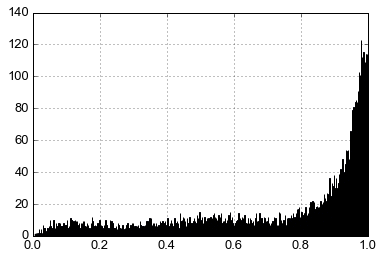

In [82]:
test_s[ test_s.process == "WW" ].pred.hist(bins=1000)

In [87]:
for process in scales.keys():
    if process in test_s.process.unique():
        print process, test_s[ (test_s.process == process) & (test_s.pred > .75)].shape[0] *  scales[process] * float(df[(df.process == process) & (df.lep_Type < 0)].shape[0])/float(test_s[test_s.process == process].shape[0])

WW 1357.90658827
DY 285.536655231
TT 216.555729053


In [ ]:
    diff                same
WW 4588.31247463     1357.90658827
DY 376.908384905     285.536655231
TT 454.19777286      216.555729053



KeyError: 'WZ_2l2q'

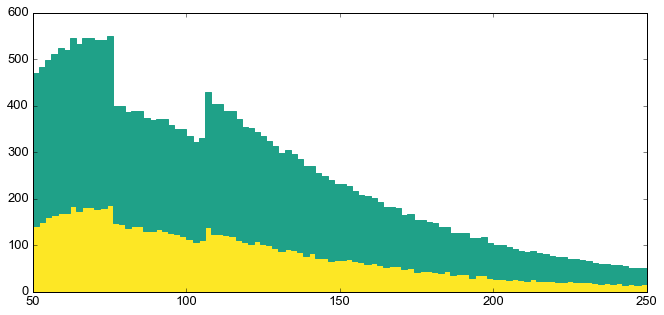

In [89]:
plot_hist(bin_df( df, "mll"))

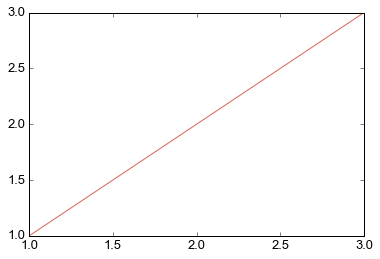

In [93]:
b = plt.pcolor(a[0])#[35:,10:])
plt.colorbar(b)

In [98]:
eval("(1./3.,2,3)")

(0.3333333333333333, 2, 3)

## same + different flavors

In [15]:
clf = clf.fit( np.float32(train[features].values) , np.float32(labels), sample_weight=weights)

In [32]:
print clf.score(np.float32(train[features].values), np.float32(labels), weights)

0.961823529412


In [16]:
pred = clf.predict_proba(np.float32(df[features].values))

In [34]:
df["pred"] = pred[:,0]

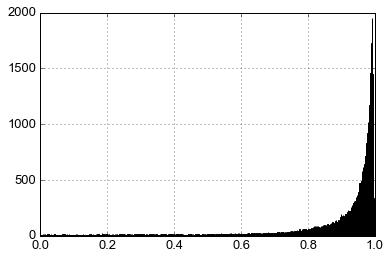

In [55]:
df[ df.WW == 1 ].pred.hist(bins=1000)

In [36]:

scales = {"WW": 19.7e3 * 59.8 /  10000431.0 ,\
          "DY": 19.7e3 * 3531.9 / 30459500. ,\
          "TT": 19.7e3 * 25.81 / 12011428.,\
          "ZZ": 19.7e3 * 9.03 / 9799908.,\
          "WZ": 19.7e3 * 1.07 / 2017979., "WJ": 1 }


for process in scales.keys():
    if process in df.keys():
        print process, df[ (df[process] == 1) & (df.pred > .96912) & (df.lep_Type > 0)].shape[0] *  scales[process],\
        df[ (df[process] == 1) & (df.pred > .96912) & (df.lep_Type < 0)].shape[0] *  scales[process]

TT 305.853610245 103.674244062
WW 3821.73461124 1266.56442707
ZZ 37.6287318207 40.7927629525
DY 1365.45077956 778.32943942
WZ 261.823028882 105.08718277


In [51]:
df.shape

(4848788, 40)

# Results as of sept 21 

### trained seperately:

Process:    | WW | DY | TT | ZZ+WZ
---         |---| ---|--- |---
same flavor |1684|395|71 | 192 
diff flavor |3799|661|139 | 220 

Significant differences

- diff DY 661 vs 106 
- diff TT 139 vs 433


### trained together:

Process:    | WW | DY | TT | ZZ+WZ
---         |---| ---|--- |---
same flavor |1057|182|36 | 101 
diff flavor |4426|485|178 | 279 